# Восстановление золота из руды

**Цель исследования** — подготовить прототип модели машинного обучения для «Цифры». Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.
<br>
<br>
**Ход исследования:**
1. Подготовка данных;<br>
2. Исследовательский анализ данных;<br>
3. Построение и обучение моделей.<br>
4. Выбор лучшей модели и ее проверка на тестовой выборке.<br>
<br>
**Данные находятся в трёх файлах:**<br>

gold_industry_train.csv — обучающая выборка;<br>
gold_industry_test.csv — тестовая выборка;<br>
gold_industry_full.csv — исходные данные.<br>
<br>

**Описание данных:**<br>

**Технологический процесс:**<br>
Rougher feed — исходное сырье<br>
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant<br>
Xanthate — ксантогенат (промотер, или активатор флотации);<br>
Sulphate — сульфат (на данном производстве сульфид натрия);<br>
Depressant — депрессант (силикат натрия).<br>
Rougher process (англ. «грубый процесс») — флотация<br>
Rougher tails — отвальные хвосты<br>
Float banks — флотационная установка<br>
Cleaner process — очистка<br>
Rougher Au — черновой концентрат золота<br>
Final Au — финальный концентрат золота<br>

**Параметры этапов:**<br>
air amount — объём воздуха<br>
fluid levels — уровень жидкости<br>
feed size — размер гранул сырья<br>
feed rate — скорость подачи<br>
<br>
**Наименование признаков:**<br>
[этап].[тип_параметра].[название_параметра]<br>
Пример: rougher.input.feed_ag<br>
Возможные значения для блока [этап]:<br>
rougher — флотация<br>
primary_cleaner — первичная очистка<br>
secondary_cleaner — вторичная очистка<br>
final — финальные характеристики<br>
Возможные значения для блока [тип_параметра]:<br>
input — параметры сырья<br>
output — параметры продукта<br>
state — параметры, характеризующие текущее состояние этапа<br>
calculation — расчётные характеристики<br>

## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

## Подготовка данных

### Чтение файлов и их изучение

Сохранение файлов в переменных:

In [2]:
train = pd.read_csv('/datasets/gold_industry_train.csv')
test = pd.read_csv('/datasets/gold_industry_test.csv')
data = pd.read_csv('/datasets/gold_industry_full.csv')

Настройка для отображения всех колонок и строк:

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Функция для первичного изучения файлов:

In [4]:
def learn_data(data):
    print('---------------------------------------HEAD---------------------------------------------------------')
    display(data.head())
    print('--------------------------------------------SHAPE---------------------------------------------------')
    display(data.shape)
    print('-----------------------------------------DTYPES-----------------------------------------------------')
    display(data.dtypes)
    print('--------------------------------------------NAN-----------------------------------------------------')
    display(data.isna().sum()) 
    print('----------------------------------------DUPLICATES--------------------------------------------------')
    print(data.duplicated().sum())

Изучение переменной train:

In [5]:
learn_data(train)

---------------------------------------HEAD---------------------------------------------------------


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,11.836743,6.005818,41885.707031,3481.779053,3520.337158,2.838687,19.793808,11.500771,7.101074,28.029297,87.107763,1.170244,5.008018,0.508728,19.154297,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,34.174427,8.547551,10.389648,19.529297,2.106679,14.936526,2.534912,7.476074,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,2.606185,14.500184,4.694824,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,1600.754587,-449.953435,1600.47

--------------------------------------------SHAPE---------------------------------------------------


(14579, 87)

-----------------------------------------DTYPES-----------------------------------------------------


date                                                   object
rougher.input.feed_au                                 float64
rougher.input.feed_ag                                 float64
rougher.input.feed_pb                                 float64
rougher.input.feed_sol                                float64
rougher.input.feed_rate                               float64
rougher.input.feed_size                               float64
rougher.input.floatbank10_sulfate                     float64
rougher.input.floatbank10_xanthate                    float64
rougher.state.floatbank10_a_air                       float64
rougher.state.floatbank10_a_level                     float64
rougher.state.floatbank10_b_air                       float64
rougher.state.floatbank10_b_level                     float64
rougher.state.floatbank10_c_air                       float64
rougher.state.floatbank10_c_level                     float64
rougher.state.floatbank10_d_air                       float64
rougher.

--------------------------------------------NAN-----------------------------------------------------


date                                                    0
rougher.input.feed_au                                   0
rougher.input.feed_ag                                   0
rougher.input.feed_pb                                  72
rougher.input.feed_sol                                 77
rougher.input.feed_rate                                 7
rougher.input.feed_size                               101
rougher.input.floatbank10_sulfate                      31
rougher.input.floatbank10_xanthate                      7
rougher.state.floatbank10_a_air                         0
rougher.state.floatbank10_a_level                       0
rougher.state.floatbank10_b_air                         0
rougher.state.floatbank10_b_level                       0
rougher.state.floatbank10_c_air                         0
rougher.state.floatbank10_c_level                       0
rougher.state.floatbank10_d_air                         0
rougher.state.floatbank10_d_level                       0
rougher.state.

----------------------------------------DUPLICATES--------------------------------------------------
0


**Вывод по переменной train:** явных дубликатов нет, есть пропуски, с которыми нужно будет поработать на этапе предобработки. Тип даты изменю на datetime в рамках предобработки данных. Все остальные типы данных корректные.

Изучение переменной test:

In [6]:
learn_data(test)

---------------------------------------HEAD---------------------------------------------------------


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,1147.248241,-500.363165,1047.279065,-500.354091,948.756608,-498.439416,849.441918,-499.255503,850.112246,-499.407112,6.168939,9.309852,95.248427,8.078957,6.500000,1.283045,1648.759906,-399.862053,1650.135395,-399.957321,1648.831890,-400.586116,1649.464582,-400.673303,34.940919,-500.150510,30.031867,-500.328335,26.033990,-500.147792,22.952306,-500.037678,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,1154.087804,-500.036580,1054.009756,-500.237335,944.138793,-496.866953,851.589767,-499.040466,851.345606,-499.122561,6.209517,9.297194,98.880538,7.984164,6.500000,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,-399.521344,1651.498591,-399.745329,34.980742,-498.131002,29.968453,-586.013330,25.971737,-499.608392,22.958448,-499.821308,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,-300.124116,1150.754676,-499.986009,1049.182824,-500.014696,948.085464,-499.997003,850.170086,-500.270334,849.557905,-500.198702,7.358308,9.000624,119.497545,8.003752,6.500000,1.259741,1647.368779,-399.788506,1648.395206,-400.166490,1648.953828,-400.468641,1649.821569,-400.071884,34.952967,-501.204647,29.927025,-500.106628,25.978253,-499.890060,23.004376,-500.014529,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,-299.778385,1152.512559,-500.338106,1052.601592,-499.695075,955.171539,-500.294989,851.957342,-499.779541,850.765662,-501.030559,6.929364,8.920717,108.080163,7.970121,6.660000,0.774909,1652.660845,-399.702218,1651.203128,-400.291472,1651.924848,

--------------------------------------------SHAPE---------------------------------------------------


(4860, 53)

-----------------------------------------DTYPES-----------------------------------------------------


date                                           object
rougher.input.feed_au                         float64
rougher.input.feed_ag                         float64
rougher.input.feed_pb                         float64
rougher.input.feed_sol                        float64
rougher.input.feed_rate                       float64
rougher.input.feed_size                       float64
rougher.input.floatbank10_sulfate             float64
rougher.input.floatbank10_xanthate            float64
rougher.state.floatbank10_a_air               float64
rougher.state.floatbank10_a_level             float64
rougher.state.floatbank10_b_air               float64
rougher.state.floatbank10_b_level             float64
rougher.state.floatbank10_c_air               float64
rougher.state.floatbank10_c_level             float64
rougher.state.floatbank10_d_air               float64
rougher.state.floatbank10_d_level             float64
rougher.state.floatbank10_e_air               float64
rougher.state.floatbank10_e_

--------------------------------------------NAN-----------------------------------------------------


date                                            0
rougher.input.feed_au                           0
rougher.input.feed_ag                           0
rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
rougher.input.feed_rate                         4
rougher.input.feed_size                        44
rougher.input.floatbank10_sulfate               3
rougher.input.floatbank10_xanthate              1
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_d_air                 0
rougher.state.floatbank10_d_level               0
rougher.state.floatbank10_e_air                 7
rougher.state.floatbank10_e_level               0
rougher.state.floatbank10_f_air                 0


----------------------------------------DUPLICATES--------------------------------------------------
0


**Вывод по переменной train:** явных дубликатов нет, есть пропуски, с которыми нужно будет поработать на этапе предобработки. Тип даты изменю на datetime в рамках предобработки данных. Все остальные типы данных корректные. Количество колонок значительно отличается от тренировочной выборки, нужно будет изучить этот вопрос на этапе предобработки.

Изучение переменной data:

In [7]:
learn_data(data)

---------------------------------------HEAD---------------------------------------------------------


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_au,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.tail_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,11.836743,6.005818,41885.707031,3481.779053,3520.337158,2.838687,19.793808,11.500771,7.101074,28.029297,87.107763,1.170244,5.008018,0.508728,19.154297,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,34.174427,8.547551,10.389648,19.529297,2.106679,14.936526,2.534912,7.476074,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,2.606185,14.500184,4.694824,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,1600.754587,-449.953435,1600.47

--------------------------------------------SHAPE---------------------------------------------------


(19439, 87)

-----------------------------------------DTYPES-----------------------------------------------------


date                                                   object
rougher.input.feed_au                                 float64
rougher.input.feed_ag                                 float64
rougher.input.feed_pb                                 float64
rougher.input.feed_sol                                float64
rougher.input.feed_rate                               float64
rougher.input.feed_size                               float64
rougher.input.floatbank10_sulfate                     float64
rougher.input.floatbank10_xanthate                    float64
rougher.state.floatbank10_a_air                       float64
rougher.state.floatbank10_a_level                     float64
rougher.state.floatbank10_b_air                       float64
rougher.state.floatbank10_b_level                     float64
rougher.state.floatbank10_c_air                       float64
rougher.state.floatbank10_c_level                     float64
rougher.state.floatbank10_d_air                       float64
rougher.

--------------------------------------------NAN-----------------------------------------------------


date                                                     0
rougher.input.feed_au                                    0
rougher.input.feed_ag                                    0
rougher.input.feed_pb                                  100
rougher.input.feed_sol                                  99
rougher.input.feed_rate                                 11
rougher.input.feed_size                                145
rougher.input.floatbank10_sulfate                       34
rougher.input.floatbank10_xanthate                       8
rougher.state.floatbank10_a_air                          1
rougher.state.floatbank10_a_level                        1
rougher.state.floatbank10_b_air                          1
rougher.state.floatbank10_b_level                        1
rougher.state.floatbank10_c_air                          1
rougher.state.floatbank10_c_level                        1
rougher.state.floatbank10_d_air                          0
rougher.state.floatbank10_d_level                       

----------------------------------------DUPLICATES--------------------------------------------------
0


**Вывод по переменной data:** явных дубликатов нет, есть пропуски, с которыми нужно будет поработать на этапе предобработки. Тип даты изменю на datetime в рамках предобработки данных. Все остальные типы данных корректные. Количество колонок совпадает с тренировочной выборкой.

### Проверка расчета эффективности обогащения:

Эффективность обогащения уже рассчитана - rougher.output.recovery.
Я посчитаю ее сама на обучающей выборке и сравню, насколько верно рассчитан признак выше.

In [8]:
C = train['rougher.output.concentrate_au'] # доля золота в концентрате после флотации/очистки;
F = train['rougher.input.feed_au'] # доля золота в сырье/концентрате до флотации/очистки;
T = train['rougher.output.tail_au'] # доля золота в отвальных хвостах после флотации/очистки.

R = train['rougher.output.recovery'] # рассчитанный коэффициент обогащения



recovery = ((C * (F - T)) / (F * (C - T))) * 100 # мой расчет коэффициента восстановления

In [9]:
print('MAE:', mean_absolute_error(R, recovery))

MAE: 9.83758577644259e-15


**Вывод по MAE:** метрика показывает, что расхождения между существующим и моим расчетом минимально. Можно использовать изначальное значение - rougher.output.recovery.

### Анализ признаков, недоступных в тестовой выборке:

Колонки, которые есть в train и data, но нет в test:

In [10]:
columns_test = []

#создаю пустой список и наполняю его теми названиями колонок, которых нет в тестовой выборке

for column in list(train.columns):
    if column not in list(test.columns):
        columns_test.append(column)
        
columns_test

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_au',
 'final.output.concentrate_ag',
 'final

**Вывод по отсутствующим колонкам:** в проекте есть указание "некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей." В основном отсутствуют параметры продукта и расчетные характеристики. Так как эти данные рассчитываются позднее, чем все остальные, считаю, что их не стоит использовать при обучении и тесте модели. После анализа данных я удалю эти признаки из тестовой выборки.

### Предобработка данных

#### Изменение типа даты

In [11]:
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d %H:%M:%S')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

#### Работа с пропусками

Так как данные индексируются датой и временем получения информации (признак date), соседние по времени параметры часто похожи. Я заполню пропуски предыдущим значением с помощью fillna и метода bfill.

In [12]:
train.fillna(method='bfill', inplace=True) # использую inplace=True, чтобы сразу внести изменения в train
train.isna().sum() #проверка

date                                                  0
rougher.input.feed_au                                 0
rougher.input.feed_ag                                 0
rougher.input.feed_pb                                 0
rougher.input.feed_sol                                0
rougher.input.feed_rate                               0
rougher.input.feed_size                               0
rougher.input.floatbank10_sulfate                     0
rougher.input.floatbank10_xanthate                    0
rougher.state.floatbank10_a_air                       0
rougher.state.floatbank10_a_level                     0
rougher.state.floatbank10_b_air                       0
rougher.state.floatbank10_b_level                     0
rougher.state.floatbank10_c_air                       0
rougher.state.floatbank10_c_level                     0
rougher.state.floatbank10_d_air                       0
rougher.state.floatbank10_d_level                     0
rougher.state.floatbank10_e_air                 

In [13]:
data.fillna(method='bfill', inplace=True) # использую inplace=True, чтобы сразу внести изменения в train
data.isna().sum() #проверка

date                                                  0
rougher.input.feed_au                                 0
rougher.input.feed_ag                                 0
rougher.input.feed_pb                                 0
rougher.input.feed_sol                                0
rougher.input.feed_rate                               0
rougher.input.feed_size                               0
rougher.input.floatbank10_sulfate                     0
rougher.input.floatbank10_xanthate                    0
rougher.state.floatbank10_a_air                       0
rougher.state.floatbank10_a_level                     0
rougher.state.floatbank10_b_air                       0
rougher.state.floatbank10_b_level                     0
rougher.state.floatbank10_c_air                       0
rougher.state.floatbank10_c_level                     0
rougher.state.floatbank10_d_air                       0
rougher.state.floatbank10_d_level                     0
rougher.state.floatbank10_e_air                 

In [14]:
test.fillna(method='bfill', inplace=True) # использую inplace=True, чтобы сразу внести изменения в train
test.isna().sum() #проверка

date                                          0
rougher.input.feed_au                         0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_sol                        0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_b_level             0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_c_level             0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level       

Теперь пропусков нет.

#### Добавление столбцов в test

Целевых признаков нет в тестовой выборке, их нужно добавить. Так как записи логируются по дате, можно с помощью объединения таблиц из общей выборки добавить недостающие колонки:

In [15]:
test = test.merge(data.loc[:, ['date','rougher.output.recovery','final.output.recovery']], on='date')
test.shape #сколько стало колонок

(4860, 55)

**Вывод:** добавлены 2 колонки таргета в тестовую выборку.

**Итоговый вывод по подготовке данных:** <br>

1. Изучены все 3 выборки.
2. По параметру rougher.output.recovery пересчитан коэффициент обогащения и проверена правильность расчетов. Все верно.
3. Выявлено, что в тренировочной и полной выборке есть такие колонки, которых нет в тестовой выборке. Принято решение эти колонки не использовать для модели, а значит, после анализа данных они будут удалены из обучающей выборки.
4. Добавлены таргеты в тестовую выборку, так как их там не было. Объединение таблиц сделано по дате.
5. Тип даты во всех выборках изменен на datetime.
6. Почищены все пропуски с заполнением их предыдущим значением.    

## Анализ данных

### Как меняется концентрация металлов (Au, Ag, Pb) в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате

#### Как меняется концентрация золота

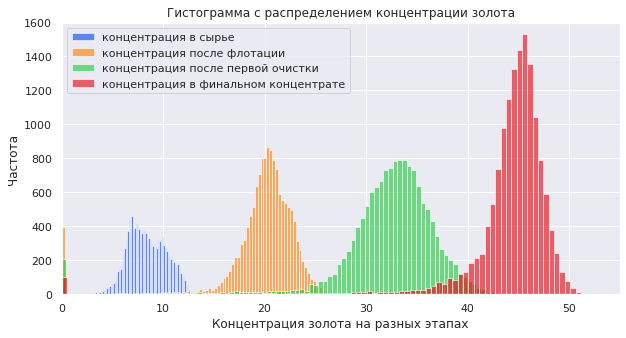

In [16]:
sns.set()
sns.set_palette('bright')
plt.figure(figsize=[10,5])

plt.hist(train['rougher.input.feed_au'], bins=100, label = 'концентрация в сырье', alpha=0.6)
plt.hist(train['rougher.output.concentrate_au'], bins=100, label = 'концентрация после флотации', alpha=0.6)
plt.hist(train['primary_cleaner.output.concentrate_au'], bins=100, label = 'концентрация после первой очистки', alpha=0.6)
plt.hist(train['final.output.concentrate_au'], bins=100, label = 'концентрация в финальном концентрате', alpha=0.6)


plt.xlim([0, 55])
plt.ylim([0, 1600])

plt.xlabel("Концентрация золота на разных этапах")
plt.ylabel("Частота")

plt.legend(loc='upper left')

plt.title("Гистограмма с распределением концентрации золота")
plt.show()

На гистограмме видно, что концентрация золота увеличивается от этапа к этапу, распределение похоже на нормальное.Также в районе значения 0 видны аномалии:

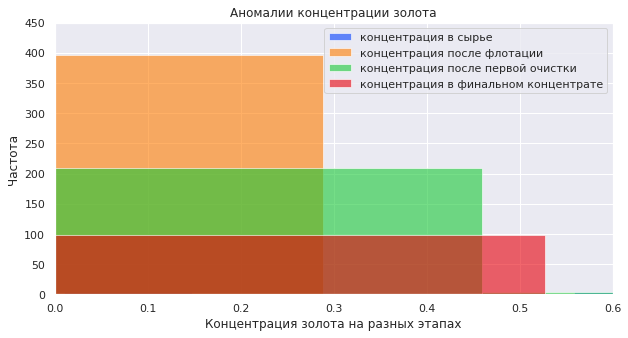

In [17]:
plt.figure(figsize=[10,5])

plt.hist(train['rougher.input.feed_au'], bins=100, label = 'концентрация в сырье', alpha=0.6)
plt.hist(train['rougher.output.concentrate_au'], bins=100, label = 'концентрация после флотации', alpha=0.6)
plt.hist(train['primary_cleaner.output.concentrate_au'], bins=100, label = 'концентрация после первой очистки', alpha=0.6)
plt.hist(train['final.output.concentrate_au'], bins=100, label = 'концентрация в финальном концентрате', alpha=0.6)


plt.xlim([0, 0.6])
plt.ylim([0, 450])

plt.xlabel("Концентрация золота на разных этапах")
plt.ylabel("Частота")

plt.legend(loc='upper right')

plt.title("Аномалии концентрации золота")
plt.show()

Получается, что аномалии есть на этих участках:
- train['rougher.output.concentrate_au'] < 0.3
- train['primary_cleaner.output.concentrate_au'] < 0.47
- train['final.output.concentrate_au'] < 0.53

#### Как меняется концентрация серебра

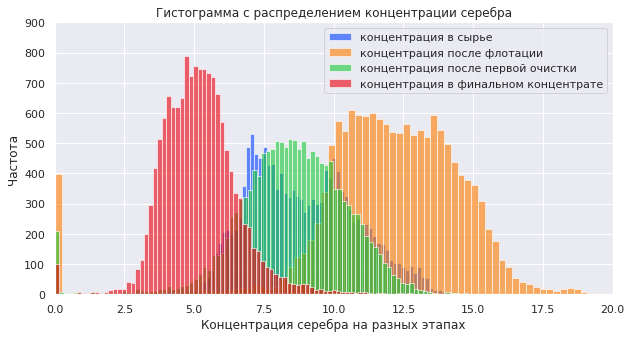

In [18]:
plt.figure(figsize=[10,5])

plt.hist(train['rougher.input.feed_ag'], bins=100, label = 'концентрация в сырье', alpha=0.6)
plt.hist(train['rougher.output.concentrate_ag'], bins=100, label = 'концентрация после флотации', alpha=0.6)
plt.hist(train['primary_cleaner.output.concentrate_ag'], bins=100, label = 'концентрация после первой очистки', alpha=0.6)
plt.hist(train['final.output.concentrate_ag'], bins=100, label = 'концентрация в финальном концентрате', alpha=0.6)


plt.xlim([0, 20])
plt.ylim([0, 900])

plt.xlabel("Концентрация серебра на разных этапах")
plt.ylabel("Частота")

plt.legend(loc='upper right')

plt.title("Гистограмма с распределением концентрации серебра")
plt.show()

Видно, что самое меньшее количества серебра на этапе финального концентрата. А больше всего после флотации. То есть нет четко прослеживаемого увеличения или уменьшения концентрации от этапа к этапу.

Аномалии:

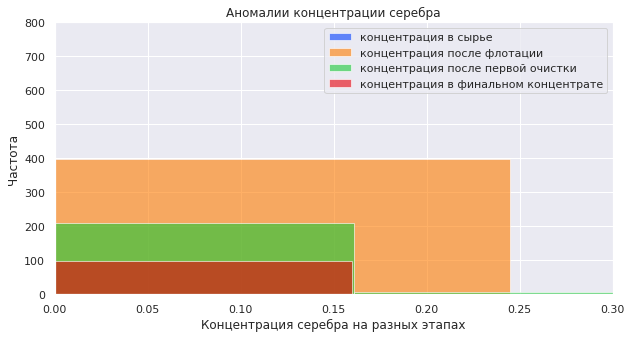

In [19]:
plt.figure(figsize=[10,5])

plt.hist(train['rougher.input.feed_ag'], bins=100, label = 'концентрация в сырье', alpha=0.6)
plt.hist(train['rougher.output.concentrate_ag'], bins=100, label = 'концентрация после флотации', alpha=0.6)
plt.hist(train['primary_cleaner.output.concentrate_ag'], bins=100, label = 'концентрация после первой очистки', alpha=0.6)
plt.hist(train['final.output.concentrate_ag'], bins=100, label = 'концентрация в финальном концентрате', alpha=0.6)


plt.xlim([0, 0.3])
plt.ylim([0, 800])

plt.xlabel("Концентрация серебра на разных этапах")
plt.ylabel("Частота")

plt.legend(loc='upper right')

plt.title("Аномалии концентрации серебра")
plt.show()

Получается, что аномалии есть на этих участках:

- train['rougher.output.concentrate_ag'] < 0.25
- train['primary_cleaner.output.concentrate_ag'] < 0.17
- train['final.output.concentrate_ag'] < 0.17

#### Как меняется концентрация Pb

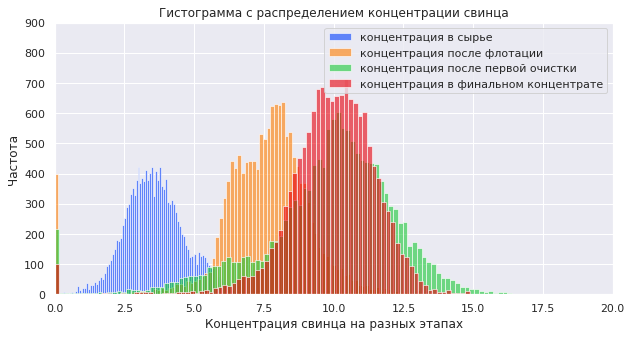

In [20]:
plt.figure(figsize=[10,5])

plt.hist(train['rougher.input.feed_pb'], bins=100, label = 'концентрация в сырье', alpha=0.6)
plt.hist(train['rougher.output.concentrate_pb'], bins=100, label = 'концентрация после флотации', alpha=0.6)
plt.hist(train['primary_cleaner.output.concentrate_pb'], bins=100, label = 'концентрация после первой очистки', alpha=0.6)
plt.hist(train['final.output.concentrate_pb'], bins=100, label = 'концентрация в финальном концентрате', alpha=0.6)

plt.xlim([0, 20])
plt.ylim([0, 900])

plt.xlabel("Концентрация свинца на разных этапах")
plt.ylabel("Частота")

plt.legend(loc='upper right')

plt.title("Гистограмма с распределением концентрации свинца")
plt.show()

Меньше всего свинца на этапе концентрации в сырье, больше всего на этапе финального концентрата и на этапе после первой очистки. То есть концентрация свинца растет от этапа к этапу.

Аномалии:

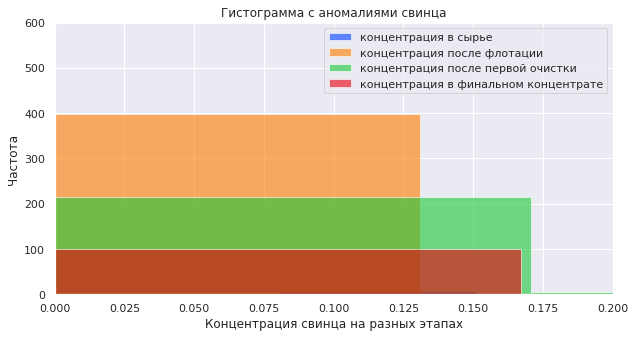

In [21]:
plt.figure(figsize=[10,5])

plt.hist(train['rougher.input.feed_pb'], bins=100, label = 'концентрация в сырье', alpha=0.6)
plt.hist(train['rougher.output.concentrate_pb'], bins=100, label = 'концентрация после флотации', alpha=0.6)
plt.hist(train['primary_cleaner.output.concentrate_pb'], bins=100, label = 'концентрация после первой очистки', alpha=0.6)
plt.hist(train['final.output.concentrate_pb'], bins=100, label = 'концентрация в финальном концентрате', alpha=0.6)

plt.xlim([0, 0.2])
plt.ylim([0, 600])

plt.xlabel("Концентрация свинца на разных этапах")
plt.ylabel("Частота")

plt.legend(loc='upper right')

plt.title("Гистограмма с аномалиями свинца")
plt.show()

Получается, что аномалии есть на этих участках:

- train['rougher.output.concentrate_pb'] < 0.13
- train['primary_cleaner.output.concentrate_pb'] < 0.175
- train['final.output.concentrate_pb'] < 0.175

### Работа с выявленными аномалиями

Создам переменную с первичным размером выборки train, чтобы потом сравнить, сколько данных было удалено:

In [22]:
train_initial_size = train.shape[0]
train_initial_size

14579

Удалю все аномалии, которые нашла:

In [23]:
train = train[(train['rougher.output.concentrate_au'] > 0.3) & \
(train['primary_cleaner.output.concentrate_au'] > 0.47) & \
(train['final.output.concentrate_au'] > 0.53) & \
(train['rougher.output.concentrate_ag'] > 0.25) & \
(train['primary_cleaner.output.concentrate_ag'] > 0.17) & \
(train['final.output.concentrate_ag'] > 0.17) & \
(train['rougher.output.concentrate_pb'] > 0.13) & \
(train['primary_cleaner.output.concentrate_pb'] > 0.175) & \
(train['final.output.concentrate_pb'] > 0.175)]

Посмотрю, сколько строк данных осталось:

In [24]:
train.shape[0]

13879

Рассчитаю, сколько % строк осталось от исходного количества:

In [25]:
print('Сколько осталось данных:', round(train.shape[0] / train_initial_size * 100, 2), '%')

Сколько осталось данных: 95.2 %


Удалено не больше 5% от исходного объема данных.

### Сравнение распределения размеров гранул исходного сырья на обучающей и тестовой выборках:

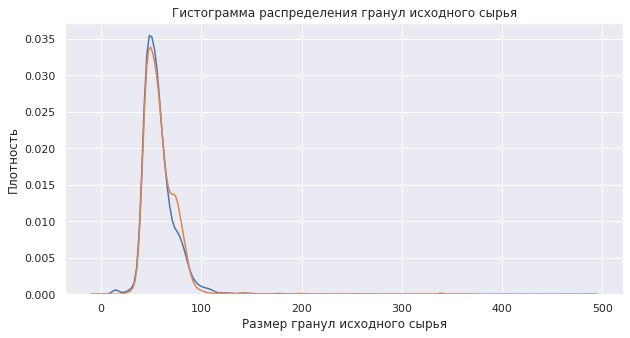

In [26]:
sns.set(rc={'figure.figsize':(10,5)})
sns.kdeplot(train['rougher.input.feed_size']);
sns.kdeplot(test['rougher.input.feed_size']);

plt.xlabel("Размер гранул исходного сырья")
plt.ylabel("Плотность")

plt.title("Гистограмма распределения гранул исходного сырья")
plt.show()

Работа с аномалиями по гранулам сырья в тренировочной выборке:

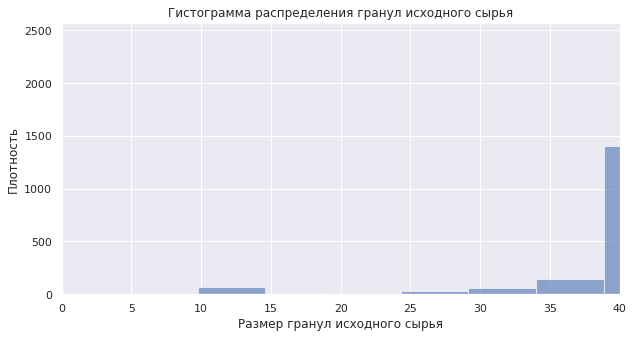

In [27]:
sns.set(rc={'figure.figsize':(10,5)})
plt.hist(train['rougher.input.feed_size'], bins=100, label = 'Размер гранул исходного сырья в тренировочной выборке', alpha=0.6)

plt.xlabel("Размер гранул исходного сырья")
plt.ylabel("Плотность")

plt.title("Гистограмма распределения гранул исходного сырья")

plt.xlim([0, 40])

plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
plt.hist(train['rougher.input.feed_size'], bins=100, label = 'Размер гранул исходного сырья в тренировочной выборке', alpha=0.6)

plt.xlabel("Размер гранул исходного сырья")
plt.ylabel("Плотность")

plt.title("Гистограмма распределения гранул исходного сырья")

plt.xlim([100, 500])

plt.show()

Удаляю аномалии:

In [28]:
train = train[(train['rougher.input.feed_size'] > 39) & \
(train['rougher.input.feed_size'] < 100)]

train.shape[0]

13229

In [29]:
print('Сколько осталось данных:', round(train.shape[0] / train_initial_size * 100, 2), '%')

Сколько осталось данных: 90.74 %


Распределение похоже как в обучающей, так и в тестовой выбрке.

### Исследование суммарной концентрации металлов в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате:

Исследуйте суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

Сначала нужно создать новые переменные с суммарной концентрациям по этапам:

In [30]:
#cуммарная концентрация ag, au, pb в сырье
rougher_input_feed_sum = (train['rougher.input.feed_au'] + train['rougher.input.feed_ag'] + train['rougher.input.feed_pb'])

#cуммарная концентрация ag, au, pb в черновом концентрате
rougher_output_concentrate_sum = (train['rougher.output.concentrate_au'] + train['rougher.output.concentrate_ag'] + \
                                  train['rougher.output.concentrate_pb'])

#cуммарная концентрация ag, au, pb после первой очистки
primary_cleaner_output_concentrate_sum = (train['primary_cleaner.output.concentrate_au'] + \
                                          train['primary_cleaner.output.concentrate_ag'] + \
                                          train['primary_cleaner.output.concentrate_pb'])

#cуммарная концентрация ag, au, pb в финальном концентрате
final_output_concentrate_sum = (train['final.output.concentrate_au'] + train['final.output.concentrate_ag'] + \
                                train['final.output.concentrate_pb'])

Теперь нужно построить гистограмму:

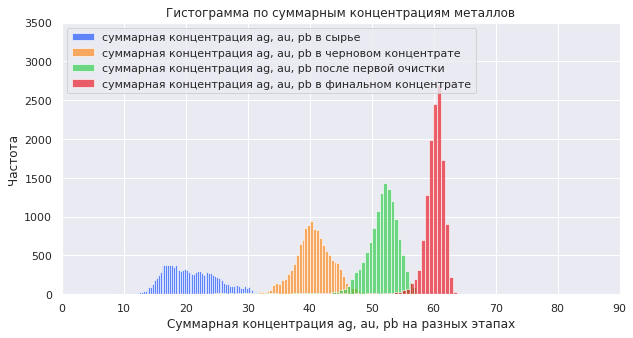

In [31]:
plt.figure(figsize=[10,5])
sns.set_palette('bright')

plt.hist(rougher_input_feed_sum, bins=100, label = 'cуммарная концентрация ag, au, pb в сырье', alpha=0.6)
plt.hist(rougher_output_concentrate_sum, bins=100, label = 'cуммарная концентрация ag, au, pb в черновом концентрате', \
         alpha=0.6)
plt.hist(primary_cleaner_output_concentrate_sum, bins=100, label = 'cуммарная концентрация ag, au, pb после первой очистки',\
         alpha=0.6)
plt.hist(final_output_concentrate_sum, bins=100, label = 'cуммарная концентрация ag, au, pb в финальном концентрате',\
         alpha=0.6)


plt.xlim([0, 90])
plt.ylim([0, 3500])

plt.xlabel("Суммарная концентрация ag, au, pb на разных этапах")
plt.ylabel("Частота")

plt.legend(loc='upper left')

plt.title("Гистограмма по суммарным концентрациям металлов")
plt.show()

Суммарная концентрация увеличивается от этапа к этапу, а ширина распределения суммарной концентрации уменьшается.

**Общий вывод по анализу данных:** 

- Концентрация золота и свинца увеличивается от этапа к этапу и максимальна на финале, а у серебра иная ситуация: самое меньшее количества серебра на этапе финального концентрата.
- Распределения размера гранул исходного сырья в обучающей и тестовой выборке похожи.
- Суммарная концентрация металлов увеличивается к финальному этапу. При этом диапазон распределения уменьшается.
- Аномалии в концентрациях металлов удалены.

## Проверка моделей и расчет sMAPE

### Удаление столбцов из тренировочной выборки

Так как я решила, что столбцы, которых нет в тестовой выборке, надо удалить, я их удалю из тренировочной выборки.

In [32]:
list_to_delete = list(set(train.columns) - set(test.columns))

train = train.drop(columns=list_to_delete)
train.shape[1] #сколько осталось колонок в train

55

**Вывод по отсутствующим колонкам:** было 87 колонок, стало 55 - удалено 32 колонки, все верно.

### Функция для вычисления итоговой sMAPE:

В первой функции я сначала рассчитаю sMAPE для одного таргета, во второй - суммарную sMAPE для 2 таргетов.

Так как с функциями pandas (abs и sum) на кросс-валидации иногда выдавался результат nan, я решила использовать функции numpy, это сработало в моем случае:

Функция sMAPE для одного таргета:

In [33]:
def smape(target, prediction):
    return (1 / len(target)) * np.sum((np.abs(target - prediction)) / ( (np.abs(target) + np.abs(prediction)) / 2)) * 100

Передача функции sMAPE скореру, чтобы можно было использовать метрику на кросс-валидации в будущем:

In [34]:
smape_scorer = make_scorer(smape, greater_is_better=False)

Функция sMAPE для двух таргетов:

In [35]:
def sum_smape(rougher, final):
    final = 0.25*rougher+0.75*final
    return final

Теперь нужно обучить разные модели и оценить их качество кросс-валидацией.<br>
Потом выбрать лучшую модель и проверить её на тестовой выборке.

### Подготовка выборок для обучения и теста

Удаляю 3 колонки (2 таргета и колонку "дата") из тренировочной выборки и делаю 2 переменные с таргетами, то же самое делаю с тестовой выборкой:

In [36]:
features_train = train.drop(columns=['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target_train_rougher = train['rougher.output.recovery']
target_train_final = train['final.output.recovery']

In [37]:
features_test = test.drop(columns=['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target_test_rougher = test['rougher.output.recovery']
target_test_final = test['final.output.recovery']

### Стандартизация данных

Для лучших расчетов делаю стандартизацию данных с StandardScaler():

In [38]:
scaler = StandardScaler()

features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

### Обучение и проверка модели LinearRegression:

Сначала получу sMAPE для модели, основанной на предсказании **rougher.output.recovery**.

In [39]:
model_lr_rougher = LinearRegression()
smape_rougher = cross_val_score(model_lr_rougher, features_train, target_train_rougher, scoring=smape_scorer, cv=3, \
                                n_jobs=-1, verbose=10)
final_smape_rougher = smape_rougher.mean()
print('sMAPE rougher:', abs(final_smape_rougher))

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ............................... score: (test=-7.790) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.992) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.413) total time=   0.4s
sMAPE rougher: 8.398314558995603


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished


Получу sMAPE для модели, основанной на предсказании **final.output.recovery**.

In [40]:
model_lr_final = LinearRegression()
smape_final = cross_val_score(model_lr_final, features_train, target_train_final, scoring=smape_scorer, cv=3, n_jobs=-1, \
                             verbose=10)
final_smape_final = smape_final.mean()
print('sMAPE final:', abs(final_smape_final))

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END .............................. score: (test=-10.309) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.673) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.875) total time=   0.6s
sMAPE final: 10.95236615541328


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Посчитаю суммарную sMAPE, основанную на 2 предсказаниях таргетов:

In [41]:
result_smape = sum_smape(smape_rougher, smape_final)
print('Summary sMAPE:', abs(result_smape.mean()))

Summary sMAPE: 10.31385325630886


### Обучение и проверка модели RandomForestRegressor:

Сначала получу sMAPE для модели, основанной на предсказании **rougher.output.recovery**.

In [42]:
best_result_r = 100
best_est_r = 0
best_depth_r = 0
for est_r in range(10, 51, 10):
    for depth_r in range (1, 11):
        model_rf_rougher = RandomForestRegressor(random_state=12345, n_estimators=est_r, max_depth=depth_r)
        smape_rougher = cross_val_score(model_rf_rougher, features_train, target_train_rougher, scoring=smape_scorer, cv=3, \
                                        n_jobs=-1, verbose=10)
        result_r = abs(smape_rougher.mean())
        if result_r < best_result_r:
            best_result_r = result_r
            best_est_r = est_r
            best_depth_r = depth_r

print("sMAPE rougher:", best_result_r, "Глубина дерева:", best_depth_r, "Estimators:", best_est_r)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ............................... score: (test=-8.953) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-4.912) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.925) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.338) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-4.625) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-6.828) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.057) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-4.638) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.012) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.793) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-4.711) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] END ............................... score: (test=-6.834) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.867) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-4.555) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] END ............................... score: (test=-7.084) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.829) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-4.522) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.539) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.032) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END ............................... score: (test=-4.829) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.695) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.108) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-4.668) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.803) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.973) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END ............................... score: (test=-4.896) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.985) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.096) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END ............................... score: (test=-5.074) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s


[CV] END ............................... score: (test=-8.076) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.991) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-4.972) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.952) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.353) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-4.710) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


[CV] END ............................... score: (test=-6.934) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.013) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-4.794) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.047) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.785) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END ............................... score: (test=-4.780) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV] END ............................... score: (test=-6.808) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.829) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] END ............................... score: (test=-4.526) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] END ............................... score: (test=-6.909) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.845) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] END ............................... score: (test=-4.653) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.486) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.087) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] END ............................... score: (test=-4.805) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.389) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.042) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] END ............................... score: (test=-4.696) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.534) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.952) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] END ............................... score: (test=-4.802) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.750) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.049) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] END ............................... score: (test=-4.930) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s


[CV] END ............................... score: (test=-8.048) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.959) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-4.999) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.936) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.367) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-4.753) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] END ............................... score: (test=-6.889) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.069) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] END ............................... score: (test=-4.869) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.003) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.801) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] END ............................... score: (test=-4.802) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


[CV] END ............................... score: (test=-6.855) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.850) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] END ............................... score: (test=-4.567) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s


[CV] END ............................... score: (test=-6.885) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.909) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] END ............................... score: (test=-4.685) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.314) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.070) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] END ............................... score: (test=-4.848) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.303) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.078) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] END ............................... score: (test=-4.814) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.470) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.000) total time=   7.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV] END ............................... score: (test=-4.850) total time=   7.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.728) total time=   6.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.098) total time=   7.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.011) total time=   7.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.867) total time=   7.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.971) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-5.008) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.923) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.364) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END ............................... score: (test=-4.785) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV] END ............................... score: (test=-6.917) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.079) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] END ............................... score: (test=-4.905) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


[CV] END ............................... score: (test=-7.033) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.812) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] END ............................... score: (test=-4.855) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s


[CV] END ............................... score: (test=-6.853) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.812) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] END ............................... score: (test=-4.604) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s


[CV] END ............................... score: (test=-6.903) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.908) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] END ............................... score: (test=-4.628) total time=   6.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.334) total time=   6.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.044) total time=   7.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV] END ............................... score: (test=-4.781) total time=   7.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.382) total time=   7.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.039) total time=   8.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV] END ............................... score: (test=-4.723) total time=   8.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.525) total time=   8.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.009) total time=   9.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV] END ............................... score: (test=-4.840) total time=   9.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   18.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.730) total time=   9.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.085) total time=   9.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


[CV] END ............................... score: (test=-4.868) total time=   9.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   19.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.854) total time=   9.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.982) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END ............................... score: (test=-4.985) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.931) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.366) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] END ............................... score: (test=-4.753) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV] END ............................... score: (test=-6.948) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.077) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] END ............................... score: (test=-4.850) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.158) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.809) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] END ............................... score: (test=-4.813) total time=   6.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s


[CV] END ............................... score: (test=-6.923) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.789) total time=   6.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV] END ............................... score: (test=-4.562) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s


[CV] END ............................... score: (test=-6.949) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.889) total time=   7.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV] END ............................... score: (test=-4.570) total time=   8.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.323) total time=   8.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.025) total time=   9.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


[CV] END ............................... score: (test=-4.678) total time=   9.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   18.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.409) total time=   8.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.999) total time=   9.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


[CV] END ............................... score: (test=-4.646) total time=  10.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   20.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.556) total time=  10.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.988) total time=  11.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s


[CV] END ............................... score: (test=-4.716) total time=  11.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   22.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.748) total time=  11.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.019) total time=  12.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s


[CV] END ............................... score: (test=-4.787) total time=  12.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   24.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.824) total time=  12.1s
sMAPE rougher: 6.421427529350413 Глубина дерева: 5 Estimators: 20


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.4s finished


Получу sMAPE для модели, основанной на предсказании **final.output.recovery**.

In [43]:
best_result_f = 100
best_est_f = 0
best_depth_f = 0
for est_f in range(10, 51, 10):
    for depth_f in range (1, 11):
        model_rf_final = RandomForestRegressor(random_state=12345, n_estimators=est_f, max_depth=depth_f)
        smape_final = cross_val_score(model_rf_final, features_train, target_train_final, scoring=smape_scorer, cv=3, \
                                     n_jobs=-1, verbose=10)
        result_f = abs(smape_final.mean())
        if result_f < best_result_f:
            best_result_f = result_f
            best_est_f = est_f
            best_depth_f = depth_f

print("sMAPE final:", best_result_f, "Глубина дерева:", best_depth_f, "Estimators:", best_est_f)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ............................... score: (test=-9.297) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.848) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.078) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.305) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-9.078) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-9.669) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.031) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-9.006) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.046) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.907) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-9.094) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-12.798) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.867) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.208) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] END .............................. score: (test=-12.403) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.056) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.390) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.971) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.277) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.520) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.803) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.466) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END ............................... score: (test=-9.520) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.659) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.600) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END ............................... score: (test=-9.716) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.917) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.686) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.060) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.758) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.327) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-8.835) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.083) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.322) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-9.026) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] END ............................... score: (test=-9.684) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.089) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-8.918) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.889) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.867) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END ............................... score: (test=-9.090) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV] END .............................. score: (test=-12.278) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.801) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] END ............................... score: (test=-9.149) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.980) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.814) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.214) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.827) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.925) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] END ............................... score: (test=-9.137) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


[CV] END .............................. score: (test=-12.108) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.067) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] END ............................... score: (test=-9.249) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


[CV] END .............................. score: (test=-12.145) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.212) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] END ............................... score: (test=-9.279) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


[CV] END .............................. score: (test=-12.254) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.185) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] END ............................... score: (test=-9.521) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.254) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.326) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-8.835) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-10.087) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.321) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.033) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.688) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.074) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.019) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.738) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.870) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] END ............................... score: (test=-9.175) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


[CV] END .............................. score: (test=-12.201) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.850) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.183) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.997) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.859) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] END ............................... score: (test=-9.179) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.681) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.846) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] END ............................... score: (test=-9.114) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.612) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.971) total time=   6.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV] END ............................... score: (test=-9.101) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.624) total time=   6.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.073) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.064) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.511) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.122) total time=   7.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.352) total time=   7.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.617) total time=   7.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.330) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.823) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.076) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.273) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END ............................... score: (test=-9.012) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] END ............................... score: (test=-9.666) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.045) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] END ............................... score: (test=-9.016) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.704) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.880) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.133) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s


[CV] END .............................. score: (test=-12.147) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.839) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.112) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.844) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.871) total time=   6.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] END ............................... score: (test=-9.069) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.594) total time=   6.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.857) total time=   7.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] END ............................... score: (test=-9.063) total time=   7.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.514) total time=   7.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.939) total time=   8.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.1s remaining:    0.0s


[CV] END ............................... score: (test=-9.002) total time=   7.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.409) total time=   8.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.029) total time=   9.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV] END ............................... score: (test=-8.953) total time=   9.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   18.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.351) total time=   9.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.063) total time=   9.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV] END ............................... score: (test=-9.133) total time=   9.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   19.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.463) total time=   9.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.330) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-8.823) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.076) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.262) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] END ............................... score: (test=-8.996) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV] END ............................... score: (test=-9.674) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.039) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] END ............................... score: (test=-8.973) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.710) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.848) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.032) total time=   5.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s


[CV] END .............................. score: (test=-12.201) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.817) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.064) total time=   6.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.832) total time=   6.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.838) total time=   7.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV] END ............................... score: (test=-8.987) total time=   8.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.630) total time=   7.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.857) total time=   8.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] END ............................... score: (test=-8.914) total time=   8.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   17.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.471) total time=   9.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.910) total time=  10.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] END ............................... score: (test=-8.869) total time=   9.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   19.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.483) total time=  10.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.009) total time=  11.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV] END ............................... score: (test=-8.802) total time=  10.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.351) total time=  11.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.058) total time=  12.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.986) total time=  12.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   24.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.463) total time=  12.1s
sMAPE final: 9.310863410074996 Глубина дерева: 2 Estimators: 50


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.2s finished


Посчитаю суммарную sMAPE, основанную на 2 предсказаниях таргетов:

In [44]:
result_smape = sum_smape(best_result_r, best_result_f)
print('Summary sMAPE:', result_smape)

Summary sMAPE: 8.58850443989385


### Обучение и проверка модели DecisionTreeRegressor:

Сначала получу sMAPE для модели, основанной на предсказании **rougher.output.recovery**.

In [45]:
best_result_r = 100
best_depth_r = 0
for depth_r in range(1, 21):
    model_dtr_rougher = DecisionTreeRegressor(random_state=12345, max_depth=depth_r)
    smape_rougher = cross_val_score(model_dtr_rougher, features_train, target_train_rougher, scoring=smape_scorer, cv=3, \
                                    n_jobs=-1, verbose=10)
    result_r = abs(smape_rougher.mean())
    if result_r < best_result_r:
        best_result_r = result_r
        best_depth_r = depth_r
        
print("sMAPE rougher:", best_result_r, "Глубина дерева:", best_depth_r)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ............................... score: (test=-9.028) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-5.060) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-7.899) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-8.438) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-4.810) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END ............................... score: (test=-6.894) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-8.129) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.158) total time=   0.2s
[CV] START .....................................................................
[CV] END ............................... score: (test=-8.210) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.871) total time=   0.2s
[CV] START .....................................................................
[CV] END ............................... score: (test=-5.508) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-6.966) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-7.902) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ............................... score: (test=-4.972) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.077) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.299) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-5.790) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.253) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.409) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-5.474) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.469) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.352) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-5.957) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.501) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.538) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.912) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-8.074) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.187) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-6.566) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-8.867) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.326) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.297) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-8.226) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.810) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.299) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-8.206) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.128) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.368) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-9.377) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.903) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-6.885) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-8.024) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.282) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-6.826) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.344) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.596) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.170) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-9.433) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.547) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.091) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-8.757) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.701) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.065) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-8.454) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.035) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.201) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-9.475) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.450) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.448) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-9.459) total time=   0.6s
sMAPE rougher: 6.650231370059287 Глубина дерева: 5


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Получу sMAPE для модели, основанной на предсказании **final.output.recovery**.

In [46]:
best_result_f = 100
best_depth_f = 0
for depth_f in range(1, 21):
    model_dtr_final = DecisionTreeRegressor(random_state=12345, max_depth=depth_f)
    smape_final = cross_val_score(model_dtr_final, features_train, target_train_final, scoring=smape_scorer, cv=3, n_jobs=-1, \
                                 verbose=10)
    result_f = abs(smape_final.mean())
    if result_f < best_result_f:
        best_result_f = result_f
        best_depth_f = depth_f
        
print("sMAPE final:", best_result_f, "Глубина дерева:", best_depth_f)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ............................... score: (test=-9.376) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-8.892) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.092) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-9.534) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-9.157) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END ............................... score: (test=-9.715) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-9.431) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-9.271) total time=   0.2s
[CV] START .....................................................................
[CV] END .............................. score: (test=-11.477) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.222) total time=   0.2s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.072) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.230) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.539) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.482) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.972) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.492) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.985) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.218) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.168) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-15.072) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.909) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.747) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-17.687) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.302) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.380) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-15.031) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.454) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.166) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-14.836) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.577) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.957) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-16.522) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.494) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.242) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-15.726) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.241) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.624) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-15.912) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.435) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-16.275) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-15.776) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.707) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-15.807) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-16.999) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-14.666) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-16.536) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-16.980) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.816) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-17.255) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-17.377) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.692) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-16.879) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-17.282) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.909) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-17.161) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-17.589) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.343) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-16.969) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-16.685) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-14.087) total time=   0.7s
sMAPE final: 9.453219331248008 Глубина дерева: 1


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Посчитаю суммарную sMAPE, основанную на 2 предсказаниях таргетов:

In [47]:
result_smape = sum_smape(best_result_r, best_result_f)
print('Summary sMAPE:', result_smape)

Summary sMAPE: 8.752472340950828


**Общий вывод по обучению моделей:** самая лучшая модель - RandomForestRegressor. Суммарная sMAPE = 8.588.

### Проверка модели на тесте:

Тестирование лучшей модели:

In [48]:
#предсказываю первый таргет
model_test_rougher = RandomForestRegressor(random_state=12345, n_estimators=20, max_depth=5)
model_test_rougher.fit(features_train, target_train_rougher)
predicted_rougher = model_test_rougher.predict(features_test)

#предсказываю второй таргет
model_test_final = RandomForestRegressor(random_state=12345, n_estimators=50, max_depth=2)
model_test_final.fit(features_train, target_train_final)
predicted_final = model_test_final.predict(features_test)

#считаю sMAPE
smape_test_rougher = smape(target_test_rougher, predicted_rougher)
smape_test_final = smape(target_test_final, predicted_final)
final_smape_test = sum_smape(smape_test_rougher, smape_test_final)

In [49]:
print('Суммарная sMAPE:', final_smape_test)

Суммарная sMAPE: 7.31444323474745


Создам константную модель, чтобы проверить адекватность модели:

In [50]:
dummy_rougher = DummyRegressor(strategy='median')
dummy_final = DummyRegressor(strategy='median')

dummy_rougher.fit(features_train, target_train_rougher)
dummy_final.fit(features_train, target_train_final)

dummy_predicted_rougher = dummy_rougher.predict(features_test)
dummy_predicted_final = dummy_final.predict(features_test)

smape_rougher = smape(target_test_rougher, dummy_predicted_rougher)
smape_final = smape(target_test_final, dummy_predicted_final)

final_smape = sum_smape(smape_rougher, smape_final)

print('Суммарная sMAPE:', final_smape)

Суммарная sMAPE: 8.288528061124824


**Вывод по тестированию:** sMAPE на тесте меньше, чем sMAPE константной модели (7.314 < 8.288). Это значит, что модель подходит для использования и она адекватна.

## Общий вывод

1. Данные были изучены и оценены.
2. Была проведена предобработка: добавлены некоторые колонки, изменен тип данных и заменены значения пропусков.
3. Проведен анализ данных по концентрациям металлов и размеру гранул исходного сырья. Концентрация золота и свинца растет к концу обработки, а концентрация серебра уменьшается. Распределение размера гранул в обучающей и тестовой выборке похоже.
4. Были созданы формулы для расчета метрики sMAPE.
5. Проверено и обучено на тренировочной выборке 3 вида моделей: LinearRegression, RandomForestRegressor, DecisionTreeRegressor.
6. По результатам отбора лучшая модель - RandomForestRegressor с суммарным sMAPE = 8.588.
7. Проведено тестирование лучшей модели с параметрами: n_estimators=30, max_depth=5 для таргета rougher и n_estimators=50, max_depth=2 для таргета final. Итоговый показатель sMAPE - 7.314.
8. Также создана константная модель с помощью DummyRegressor. Итоговый показатель sMAPE -  8.288

**Тестирование проведено успешно, так как показатель sMAPE у модели на тесте меньше, чем у константной модели.**

**Выбранная модель - RandomForestRegressor.**